In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ss
from sklearn import tree

In [24]:
#load data, in sparse format
def load_data(filename):
    f = open('dorothea/%s.data' % filename)
    I,J = [],[]
    for k in range(100000):
        line = f.readline()
        if len(line) == 0:
            print('done')
            break

        line = [int(x) for x in line.split()]
        J.extend(line)
        I.extend(k for i in range(len(line)))

    return ss.coo_matrix((np.ones(len(I)), (I,J)))


def load_labels(filename):
    f = open('dorothea/%s.labels' % filename)
    y = []
    for k in range(100000):
        line = f.readline()
        
        if len(line) == 0:
            print('done')
            break
        y.append(int(line))
    return np.array(y)


Xtrain = load_data('dorothea_train')
ytrain = load_labels('dorothea_train')

Xtest= load_data('dorothea_valid')
ytest = load_labels('dorothea_valid')

print( Xtrain.shape,  Xtest.shape, Xtrain.nnz)

done
done
done
done
(800, 100001) (350, 100001) 727760


In [25]:
print (Xtrain)

  (0, 191)	1.0
  (0, 367)	1.0
  (0, 614)	1.0
  (0, 634)	1.0
  (0, 711)	1.0
  (0, 1202)	1.0
  (0, 1220)	1.0
  (0, 1311)	1.0
  (0, 1472)	1.0
  (0, 1730)	1.0
  (0, 2281)	1.0
  (0, 2572)	1.0
  (0, 2602)	1.0
  (0, 2611)	1.0
  (0, 2824)	1.0
  (0, 2855)	1.0
  (0, 2940)	1.0
  (0, 3149)	1.0
  (0, 3313)	1.0
  (0, 3560)	1.0
  (0, 3568)	1.0
  (0, 3824)	1.0
  (0, 4185)	1.0
  (0, 4266)	1.0
  (0, 4366)	1.0
  :	:
  (799, 97876)	1.0
  (799, 97899)	1.0
  (799, 98032)	1.0
  (799, 98266)	1.0
  (799, 98277)	1.0
  (799, 98301)	1.0
  (799, 98342)	1.0
  (799, 98353)	1.0
  (799, 98413)	1.0
  (799, 98419)	1.0
  (799, 98448)	1.0
  (799, 98458)	1.0
  (799, 98468)	1.0
  (799, 98635)	1.0
  (799, 98892)	1.0
  (799, 99118)	1.0
  (799, 99337)	1.0
  (799, 99621)	1.0
  (799, 99625)	1.0
  (799, 99739)	1.0
  (799, 99745)	1.0
  (799, 99755)	1.0
  (799, 99828)	1.0
  (799, 99955)	1.0
  (799, 99967)	1.0


In [26]:
def get_class_balance(y):
    # Return a tuple of the number of positive and negative examples in y
    return np.sum(y == 1), np.sum(y == -1)

print ('class balance is currently %.2f  +1, %.2f -1' % get_class_balance(ytrain))

class balance is currently 78.00  +1, 722.00 -1


In [27]:
def get_misclass(y,yhat):
    return np.mean(y != yhat)

def get_f1(y,yhat):
    true_positives = np.sum((y == 1) & (yhat == 1))
    false_positives = np.sum((y == -1) & (yhat == 1))
    false_negatives = np.sum((y == 1) & (yhat == -1))
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    return (2 * precision * recall) / (precision + recall)

depth = 3
clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
clf = clf.fit(Xtrain, ytrain)


print(get_misclass(ytrain, clf.predict(Xtrain)), get_f1(ytrain, clf.predict(Xtrain)))
print(get_misclass(ytest, clf.predict(Xtest)), get_f1(ytest, clf.predict(Xtest)))

0.04125 0.7724137931034484
0.07142857142857142 0.6031746031746031


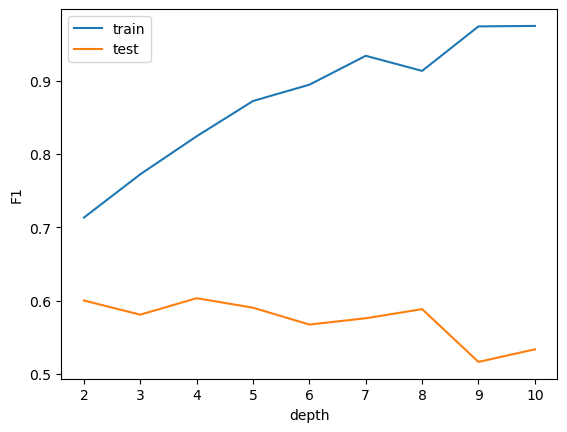

In [28]:
# Sweep over the depth of the tree and plot the F1 scores on train and test

depths = range(2, 11)
train_f1 = []
test_f1 = []
for depth in depths:
    clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
    clf = clf.fit(Xtrain, ytrain)
    train_f1.append(get_f1(ytrain, clf.predict(Xtrain)))
    test_f1.append(get_f1(ytest, clf.predict(Xtest)))

plt.plot(depths, train_f1, label='train')
plt.plot(depths, test_f1, label='test')
plt.legend()
plt.xlabel('depth')
plt.ylabel('F1')
plt.show()

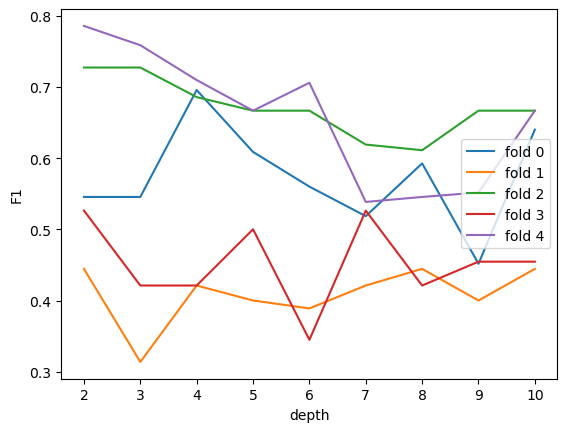

In [32]:
# Implement 5-fold cross validation and plot the F1 score over the validation set
# for each fold. Plot the average F1 score over each fold on the training set.

k = 5
depths = range(2, 11)
xPartition = np.array_split(Xtrain.A, k)
yPartition = np.array_split(ytrain, k)
for i in range(k):
    f1_scores = []
    xPartitionCopy = xPartition.copy()
    yPartitionCopy = yPartition.copy()
    # Split the data into training and validation sets using np.array_split
    X_val = ss.coo_matrix(xPartitionCopy[i])
    y_val = yPartitionCopy[i]
    xPartitionCopy = np.delete(xPartitionCopy, i, 0)
    yPartitionCopy = np.delete(yPartitionCopy, i, 0)
    X_train = ss.coo_matrix(np.concatenate(xPartitionCopy))
    y_train = np.concatenate(yPartitionCopy)
    # Loop over depths and train a decision tree classifier on the training set
    # and evaluate the F1 score on the validation set and plot the results
    for depth in depths:
        clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
        clf = clf.fit(X_train, y_train)
        f1_scores.append(get_f1(y_val, clf.predict(X_val)))
    plt.plot(depths, f1_scores, label='fold %d' % i)
plt.legend()
plt.xlabel('depth')
plt.ylabel('F1')
plt.show()

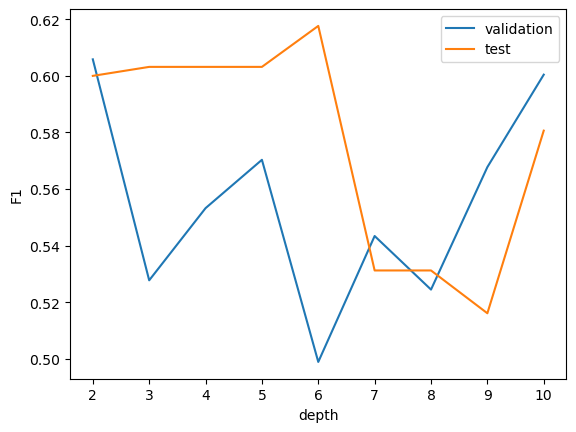

In [46]:
# Plot average validation F1 score against the test F1 score for each depth
depths = range(2, 11)
val_f1 = []
for depth in depths:
    f1_scores = []
    for i in range(k):
        xPartitionCopy = xPartition.copy()
        yPartitionCopy = yPartition.copy()
        X_val = ss.coo_matrix(xPartitionCopy[i])
        y_val = yPartitionCopy[i]
        xPartitionCopy = np.delete(xPartitionCopy, i, 0)
        yPartitionCopy = np.delete(yPartitionCopy, i, 0)
        X_train = ss.coo_matrix(np.concatenate(xPartitionCopy))
        y_train = np.concatenate(yPartitionCopy)
        clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
        clf = clf.fit(X_train, y_train)
        f1_scores.append(get_f1(y_val, clf.predict(X_val)))
    val_f1.append(np.mean(f1_scores))
plt.plot(depths, val_f1, label='validation')
plt.plot(depths, test_f1, label='test')
plt.legend()
plt.xlabel('depth')
plt.ylabel('F1')
plt.show()